 # Intrusion Detection in IoT using AdaBoost Model

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import seaborn as sns
from joblib import dump, load
%matplotlib inline

In [2]:
# Concatenating Dataset
folder_path = 'dataset'
file_paths = glob.glob(folder_path + '/*.csv')

df = pd.DataFrame()
for file_path in tqdm(file_paths, desc='Processing files', unit='file'):
    dff = pd.read_csv(file_path)
    df = pd.concat([df, dff], ignore_index=True)

Processing files: 100%|██████████████████████████████████████████████████████████████| 35/35 [01:29<00:00,  2.57s/file]


In [3]:
print(df.keys())


Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8706783 entries, 0 to 8706782
Data columns (total 47 columns):
 #   Column           Dtype  
---  ------           -----  
 0   flow_duration    float64
 1   Header_Length    float64
 2   Protocol Type    float64
 3   Duration         float64
 4   Rate             float64
 5   Srate            float64
 6   Drate            float64
 7   fin_flag_number  float64
 8   syn_flag_number  float64
 9   rst_flag_number  float64
 10  psh_flag_number  float64
 11  ack_flag_number  float64
 12  ece_flag_number  float64
 13  cwr_flag_number  float64
 14  ack_count        float64
 15  syn_count        float64
 16  fin_count        float64
 17  urg_count        float64
 18  rst_count        float64
 19  HTTP             float64
 20  HTTPS            float64
 21  DNS              float64
 22  Telnet           float64
 23  SMTP             float64
 24  SSH              float64
 25  IRC              float64
 26  TCP              float64
 27  UDP         

In [5]:
# Handling missing values and mapping data
[features for features in df.columns if df[features].isnull().sum() > 0]


[]

In [6]:
# Unique labels in the dataset
print(df['label'].nunique())



34


In [7]:
print(df['label'].unique())

['DDoS-RSTFINFlood' 'DoS-TCP_Flood' 'DDoS-ICMP_Flood' 'DoS-UDP_Flood'
 'DoS-SYN_Flood' 'Mirai-greeth_flood' 'DDoS-SynonymousIP_Flood'
 'Mirai-udpplain' 'DDoS-SYN_Flood' 'DDoS-PSHACK_Flood' 'DDoS-TCP_Flood'
 'DDoS-UDP_Flood' 'BenignTraffic' 'MITM-ArpSpoofing'
 'DDoS-ACK_Fragmentation' 'Mirai-greip_flood' 'DoS-HTTP_Flood'
 'DDoS-ICMP_Fragmentation' 'Recon-PortScan' 'DNS_Spoofing'
 'DDoS-UDP_Fragmentation' 'Recon-OSScan' 'XSS' 'DDoS-HTTP_Flood'
 'Recon-HostDiscovery' 'CommandInjection' 'VulnerabilityScan'
 'DDoS-SlowLoris' 'Backdoor_Malware' 'BrowserHijacking'
 'DictionaryBruteForce' 'SqlInjection' 'Recon-PingSweep'
 'Uploading_Attack']


In [8]:
# Sub-class Mapping , classify each attack separately by their family
mapping = {
    'DDoS-ICMP_Flood': 'DDoS',
    'DDoS-UDP_Flood': 'DDoS',
    'DDoS-TCP_Flood': 'DDoS',
    'DDoS-PSHACK_Flood': 'DDoS',
    'DDoS-SYN_Flood': 'DDoS',
    'DDoS-RSTFINFlood': 'DDoS',
    'DDoS-SynonymousIP_Flood': 'DDoS',
    'DoS-UDP_Flood': 'DoS',
    'DoS-TCP_Flood': 'DoS',
    'DoS-SYN_Flood': 'DoS',
    'BenignTraffic': 'Benign',
    'Mirai-greeth_flood': 'Mirai',
    'Mirai-udpplain': 'Mirai',
    'Mirai-greip_flood': 'Mirai',
    'DDoS-ICMP_Fragmentation': 'DDoS',
    'MITM-ArpSpoofing': 'MITM',
    'DDoS-UDP_Fragmentation': 'DDoS',
    'DDoS-ACK_Fragmentation': 'DDoS',
    'DNS_Spoofing': 'Spoofing',
    'Recon-HostDiscovery': 'Recon',
    'Recon-OSScan': 'Recon',
    'Recon-PortScan': 'Recon',
    'DoS-HTTP_Flood': 'DoS',
    'VulnerabilityScan': 'Recon',
    'DDoS-HTTP_Flood': 'DDoS',
    'DDoS-SlowLoris': 'DDoS',
    'DictionaryBruteForce': 'BruteForce',
    'BrowserHijacking': 'Hijacking',
    'CommandInjection': 'Injection',
    'SqlInjection': 'Injection',
    'XSS': 'XSS',
    'Backdoor_Malware': 'Malware',
    'Recon-PingSweep': 'Recon',
    'Uploading_Attack': 'Upload'
}


In [9]:
df['label'] = df['label'].map(mapping)

In [10]:
# Checking the distribution of labels after mapping
print(df['label'].value_counts())

label
DDoS          6338817
DoS           1507476
Mirai          491428
Benign         205116
Recon           65827
MITM            57612
Spoofing        33527
BruteForce       2399
Injection        1974
Hijacking        1062
XSS               675
Malware           637
Upload            233
Name: count, dtype: int64


In [11]:
predictorNames = ['flow_duration', 'Header_Length', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

In [12]:
predictors = df[predictorNames]
response = df['label']

In [13]:
# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.2, random_state=42, stratify=response)


In [14]:
# Importing Libraries:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import seaborn as sns
from joblib import dump
%matplotlib inline

In [15]:
# AdaBoost Model
template = DecisionTreeClassifier(max_depth=5)
classificationEnsemble = AdaBoostClassifier(estimator=template, n_estimators=100, learning_rate=0.1)
classificationEnsemble.fit(X_train, y_train)
y_pred = classificationEnsemble.predict(X_test)

# Calculate metrics
Accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')  
precision = precision_score(y_test, y_pred, average='weighted')  
f1 = f1_score(y_test, y_pred, average='weighted') 

# Print results
print('AdaBoost:')
print('Accuracy:', Accuracy * 100)
print('Recall:', recall * 100)
print('Precision:', precision * 100)
print('F1 Score:', f1 * 100)
print('******************************************')

AdaBoost:
Accuracy: 59.69023009067067
Recall: 59.69023009067067
Precision: 98.83970956103856
F1 Score: 71.47361884510947
******************************************


In [17]:
# Print metrics
print('Adaboost Classifier:')
print(f'Accuracy: {Accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Adaboost Classifier:
Accuracy: 59.69%
Recall: 59.69%
Precision: 98.84%
F1 Score: 71.47%


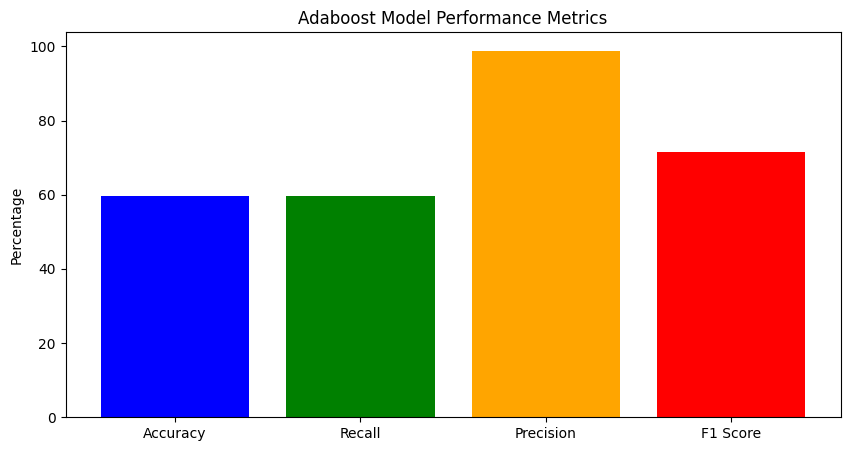

In [19]:
# Plot the metrics
metrics = {'Accuracy': Accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1}
plt.figure(figsize=(10, 5))
plt.bar(metrics.keys(), [v * 100 for v in metrics.values()], color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Percentage')
plt.title('Adaboost Model Performance Metrics')
plt.show()


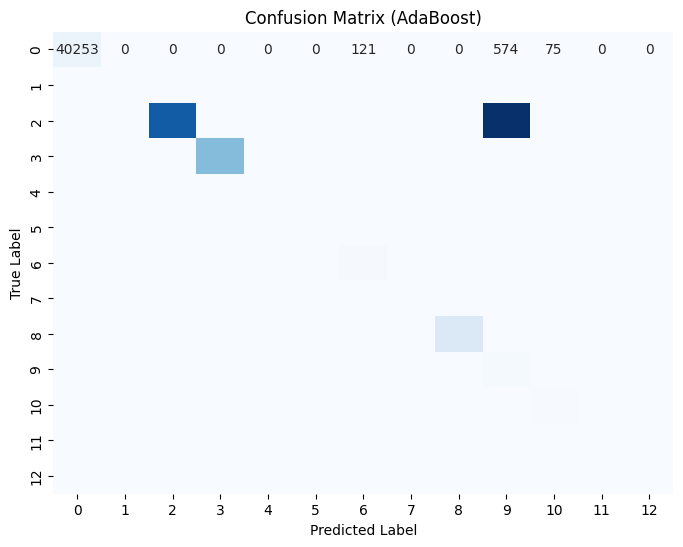

In [22]:
# Confusion Matrix for AdaBoost

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (AdaBoost)')
plt.show()

In [25]:
# Save the MLP Model:
dump(classificationEnsemble, 'adaboost_sub_model.joblib')

['adaboost_sub_model.joblib']